In [43]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.colors import Normalize
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.transforms import Bbox
from shapely.geometry import Polygon, MultiPolygon
from PIL import Image
import pickle
import requests

In [2]:
with open(r"HighRankedMovies_ByCountry.pickle", "rb") as input_file:
    movies = pickle.load(input_file)

In [3]:
def select_entry(data):

    Selected_Films = {}

    for country in data:
        max_popularity_entry = max(data[country]['movies'], key= lambda x: x.get('vote_average'))
        # Filter out entries where the country in question is not the primary film.
        if max_popularity_entry['country'][0] == country:
            selected_entry = max_popularity_entry.copy()
        else:
            filtered_data = [entry for entry in data[country]['movies'] if entry['country'][0] == country]
            if filtered_data:
                max_popularity_entry = max(filtered_data, key=lambda x: x.get('vote_average')).copy()
        Selected_Films[country] = max_popularity_entry
    return Selected_Films

Movies2Plot = select_entry(movies)

In [7]:
def RetrieveImages(movies):

    base_path = 'https://image.tmdb.org/t/p/original'

    for country in movies:
        img_data = requests.get(base_path + movies[country]['poster_path']).content

        with open('Posters/' + country + '.jpg', 'wb') as handler:
            handler.write(img_data)

# Save movie posters to the Posters directory
RetrieveImages(Movies2Plot)

In [50]:
def create_image_annotation(ax, image_path, coordinates, zoom=1):
    image = plt.imread(image_path)

    if isinstance(coordinates, MultiPolygon):
        coords = coordinates.convex_hull.exterior.coords.xy
    elif isinstance(coordinates, Polygon):
        coords = coordinates.exterior.coords.xy

    ax.imshow(image, extent=(min(coords[0]), max(coords[0]), min(coords[1]), max(coords[1])), aspect='auto', zorder=2)

C:\Users\Luke\AppData\Local\Temp\ipykernel_19064\2504288738.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


No film listed for  Fiji
No film listed for  Tanzania
No film listed for  W. Sahara
No film listed for  Uzbekistan
No film listed for  Papua New Guinea
No film listed for  Dem. Rep. Congo
No film listed for  Somalia
No film listed for  Sudan
No film listed for  Chad
No film listed for  Haiti
No film listed for  Dominican Rep.
No film listed for  Falkland Is.
No film listed for  Greenland
No film listed for  Fr. S. Antarctic Lands
No film listed for  Timor-Leste
No film listed for  Lesotho
No film listed for  Costa Rica
No film listed for  Nicaragua
No film listed for  Honduras
No film listed for  El Salvador
No film listed for  Guatemala
No film listed for  Belize
No film listed for  Guyana
No film listed for  Suriname
No film listed for  Jamaica
No film listed for  Zimbabwe
No film listed for  Namibia
No film listed for  Senegal
No film listed for  Mali
No film listed for  Mauritania
No film listed for  Benin
No film listed for  Niger
No film listed for  Cameroon
No film listed for  T

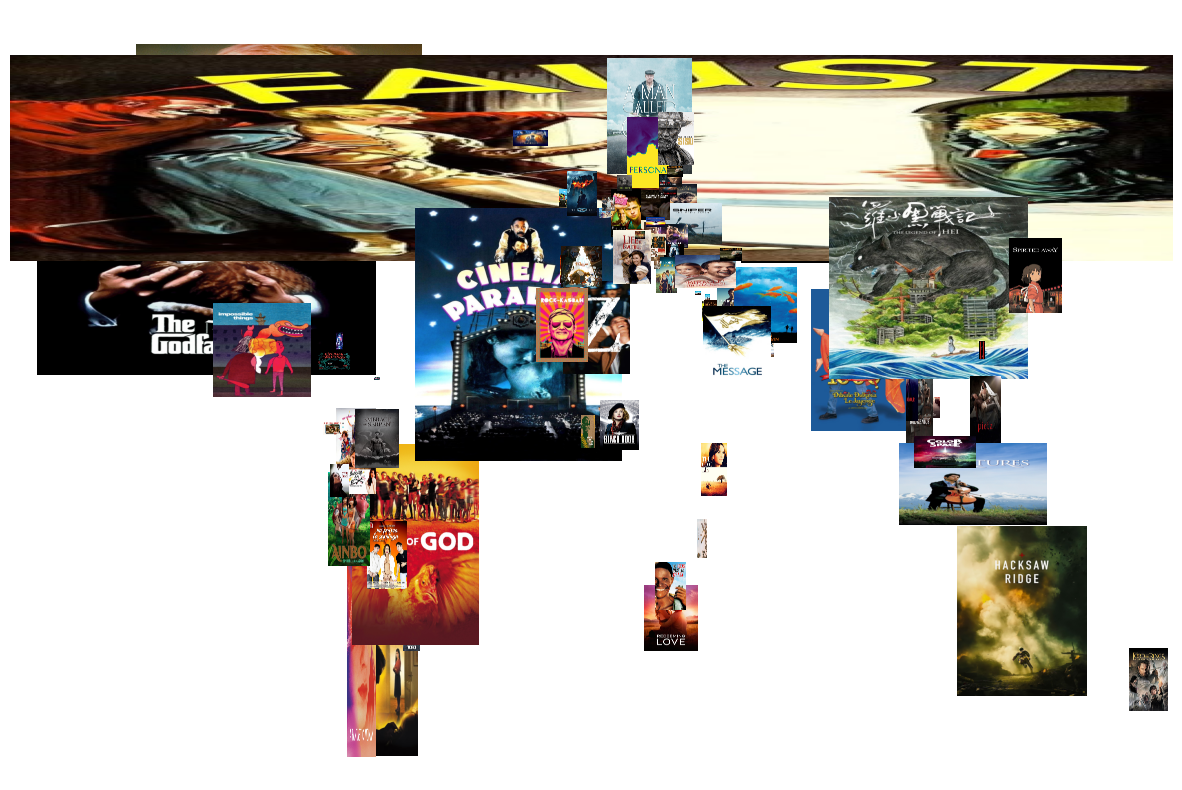

In [49]:


# Load the world map data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(15, 10))

# Loop through each country and plot it
for idx, row in world.iterrows():
    country_name = row['name']
    geometry = row['geometry']
    boundary = geometry.boundary

    if not os.path.exists(f'Posters/{country_name}.jpg'):
        print("No film listed for ", country_name)
        continue

    if geometry.geom_type == 'MultiPolygon':
        coordinates = geometry
    else:
        coordinates = geometry

    # Example: Use a sample JPEG image for each country
    image_path = f'Posters/{country_name}.jpg'

    create_image_annotation(ax, image_path, coordinates, zoom=0.2)

# Set plot limits
ax.set_xlim([-180, 180])
ax.set_ylim([-60, 90])

# Hide the axes
ax.axis('off')

# Show the plot
plt.show()